In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error


In [40]:

url='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'


df = pd.read_csv(url)


df = df.fillna(0) # fill NaN with 0 
df['median_house_value'] = np.log1p(df['median_house_value']) # transform to log(values)

df.loc[df['ocean_proximity'] == '<1H OCEAN', 'ocean_proximity'] = '1H OCEAN'
#split 60 % 20% 20%

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)


In [41]:
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']




In [42]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)


In [43]:
# Question 1
from sklearn.tree import export_text
model= DecisionTreeRegressor(max_depth=1)

model.fit(X_train, y_train)

y_pred=model.predict(X_val)
print(export_text(model, feature_names=dv.get_feature_names()))
print(mean_squared_error(y_val, y_pred,squared=False).round(2))

#Which feature is used for splitting the data? 
#Ans :  ocean_proximity=INLAND

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]

0.47


/home/kwan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
from sklearn.ensemble import RandomForestRegressor
model= RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
model.fit(X_train, y_train)
y_pred=model.predict(X_val)
print(mean_squared_error(y_val, y_pred,squared=False).round(2))

#Question 2
#RMSE= 0.25

0.25


In [27]:

scores=[]
for n in range(10,200,10):

    model= RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_val)
    scores.append(mean_squared_error(y_val, y_pred,squared=False).round(2))


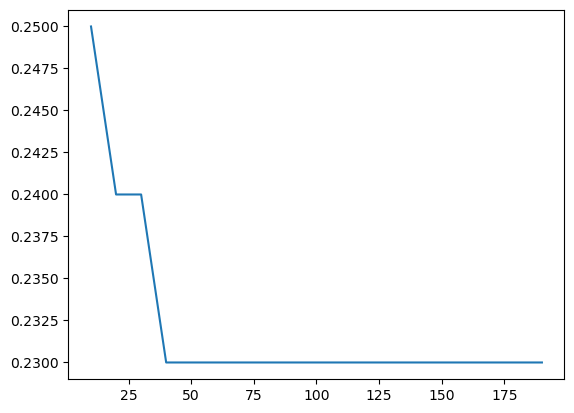

In [31]:

#Question 3
# After which value of n_estimators does RMSE stop improving
# Ans: 55
plt.plot(range(10,200,10),scores)

In [35]:
m=np.arange(10,201,10)
scores=[]
max_depth= [10, 15, 20, 25]
for n in range(10, 201, 10):
    for d in max_depth:
        regr = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1,max_depth=d)
        regr.fit(X_train, y_train)
        y_pred=regr.predict(X_val)
        score=mean_squared_error(y_val, y_pred,squared=False).round(4)

        scores.append((n,d,score))



<AxesSubplot:xlabel='None-max_depth', ylabel='n_esti'>

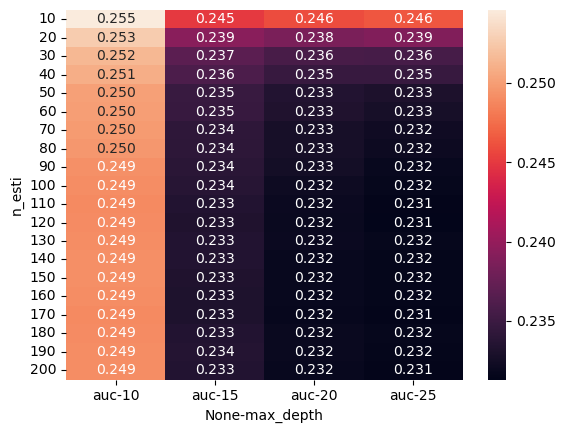

In [36]:
columns = ['n_esti', 'max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='n_esti', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)


sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")


Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

    Train the model with these parametes:
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1 (optional)
    Get the feature importance information from this model



In [45]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)


for i, k in zip(dv.get_feature_names(), rf.feature_importances_):
    print(i,k)


households 0.016387382721975895
housing_median_age 0.03314545802888494
latitude 0.10125584919636603
longitude 0.09647021370105628
median_income 0.3633258427603735
ocean_proximity=1H OCEAN 0.0024888027585429112
ocean_proximity=INLAND 0.3109008417080609
ocean_proximity=ISLAND 0.0003568062629467623
ocean_proximity=NEAR BAY 0.00048036979631206085
ocean_proximity=NEAR OCEAN 0.004698766933197919
population 0.030776921187228586
total_bedrooms 0.01917163182045455
total_rooms 0.020541113124599636


/home/kwan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:


pd.DataFrame({'col_name': rf.feature_importances_}, index=dv.get_feature_names()).sort_values(by='col_name', ascending=False)



,col_name
median_income,0.363326
ocean_proximity=INLAND,0.310901
latitude,0.101256
longitude,0.096470
housing_median_age,0.033145
population,0.030777
total_rooms,0.020541
total_bedrooms,0.019172
households,0.016387
ocean_proximity=NEAR OCEAN,0.004699


In [57]:

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
eta=np.arange(0.1,1.1,0.1)
sc=[]
for n in eta:
    
    xgb_params = {
        'eta':n, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100)

    y_pred = model.predict(dval)
    score=mean_squared_error(y_val, y_pred,squared=False).round(4)
    sc.append(score)

/home/kwan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
sc

[0.2305,
 0.2285,
 0.2261,
 0.2332,
 0.2362,
 0.2437,
 0.2557,
 0.2608,
 0.2713,
 0.2788]